In [13]:
#importing all necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.cluster import KMeans

#load csv file with the correct delimiter 
file_path = 'malware-capture-csv/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv'
data = pd.read_csv(file_path, delimiter='|')



/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_12145/2455735687.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.replace('-', np.nan, inplace=True)
/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_12145/2455735687.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['duration'] = pd.to_numeric(data_selected['duration'], errors='coerce')
/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_12145/2455735687.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

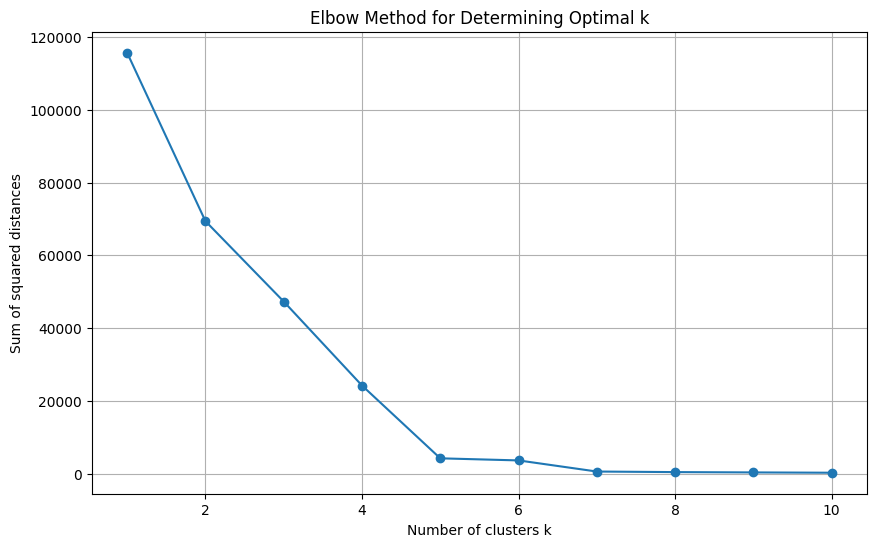

In [15]:
# Select relevant columns
selected_columns = [
    'ts', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 
    'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'label'
]
data_selected = data[selected_columns]

# Data Cleaning
data_selected.replace('-', np.nan, inplace=True)
data_selected['duration'] = pd.to_numeric(data_selected['duration'], errors='coerce')
data_selected['orig_bytes'] = pd.to_numeric(data_selected['orig_bytes'], errors='coerce')
data_selected['resp_bytes'] = pd.to_numeric(data_selected['resp_bytes'], errors='coerce')

# Fill missing values
data_selected['duration'].fillna(data_selected['duration'].median(), inplace=True)
data_selected['orig_bytes'].fillna(0, inplace=True)
data_selected['resp_bytes'].fillna(0, inplace=True)

# One-hot encode 'proto'
encoder = OneHotEncoder()
proto_encoded = encoder.fit_transform(data_selected[['proto']]).toarray()  # Convert sparse matrix to dense matrix

# Combine the encoded proto data with other numerical features
features = np.hstack((data_selected[['duration', 'orig_bytes', 'resp_bytes']].values, proto_encoded))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
sse = []
k_list = range(1, 11)  # Check from 1 to 10 clusters
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# Plot the SSE values for each k
plt.figure(figsize=(10, 6))
plt.plot(k_list, sse, marker='o')
plt.title('Elbow Method for Determining Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()



/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_12145/4064424617.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['cluster'] = cluster_labels
/var/folders/qj/554m8prd38q7hks9ryklzp5m0000gn/T/ipykernel_12145/4064424617.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['label_encoded'] = label_encoder.fit_transform(data_selected['label'])


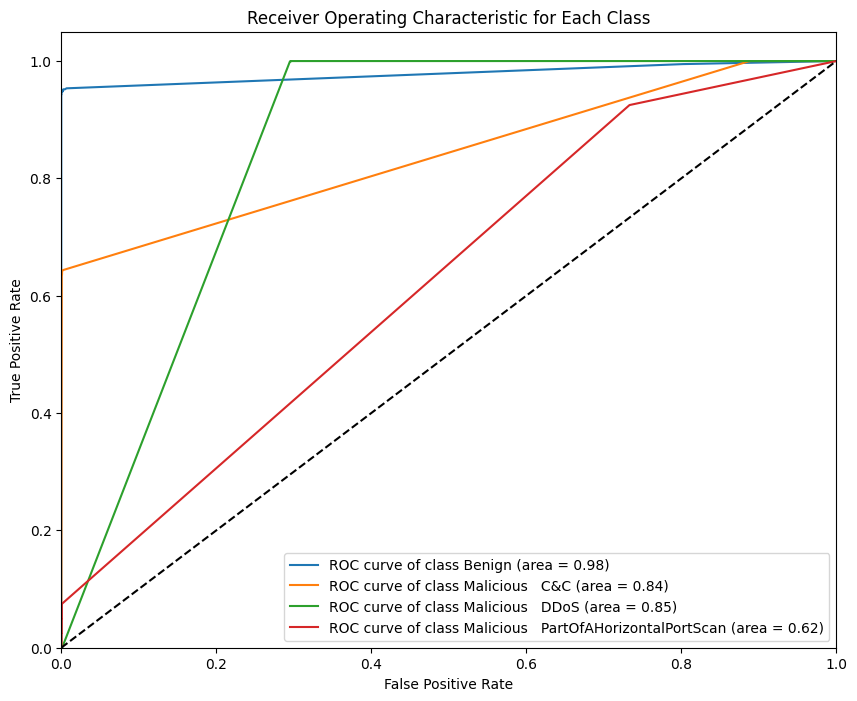

In [18]:
# K-means clustering (use elbow method results to pick k)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)
data_selected['cluster'] = cluster_labels

# Supervised Learning Preparation
label_encoder = LabelEncoder()
data_selected['label_encoded'] = label_encoder.fit_transform(data_selected['label'])
X = features_scaled  # Features already scaled
y = data_selected['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# ROC Curve
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
y_pred_proba = rf_classifier.predict_proba(X_test)
fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Predict on the test set and evaluate the model
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.886520737327189
Confusion Matrix:
 [[ 549    6   26    0]
 [   1 1287  713    1]
 [   1    0 4319    1]
 [   0    1   38    1]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       581
           1       0.99      0.64      0.78      2002
           2       0.85      1.00      0.92      4321
           3       0.33      0.03      0.05        40

    accuracy                           0.89      6944
   macro avg       0.79      0.65      0.68      6944
weighted avg       0.90      0.89      0.88      6944



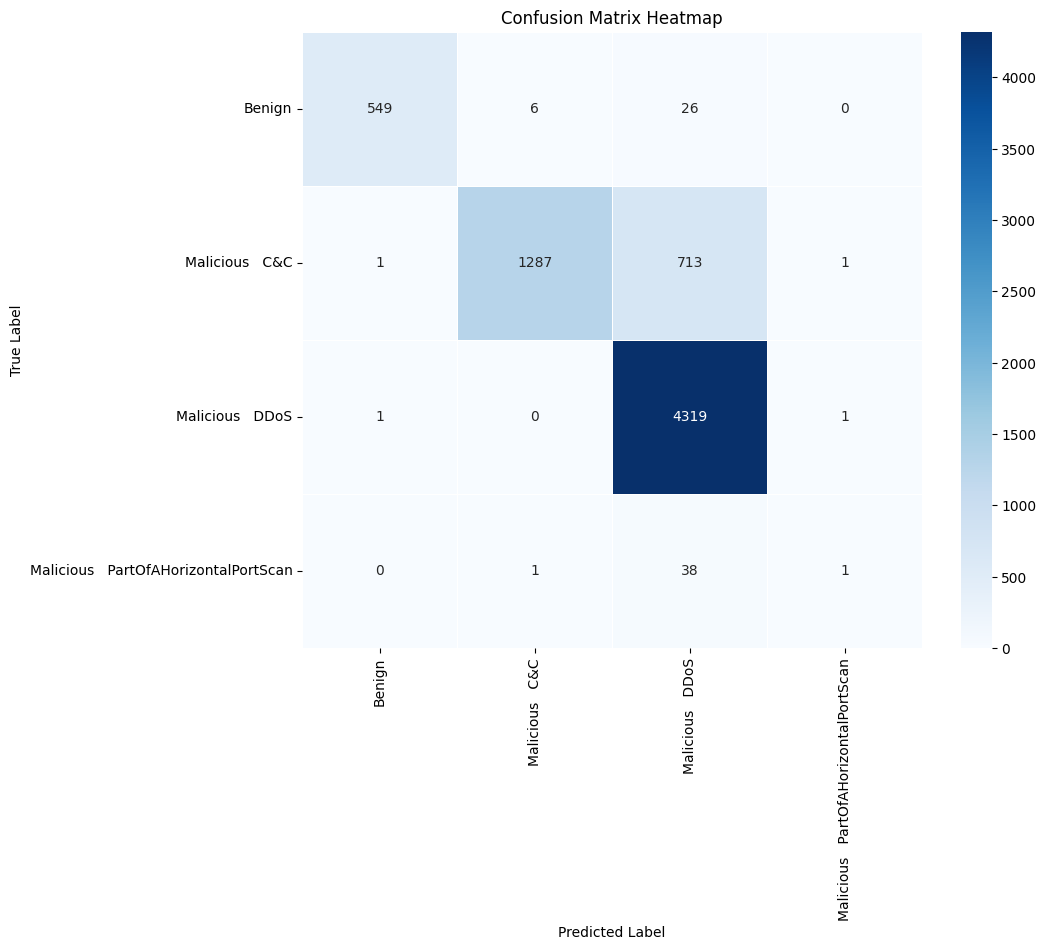

In [17]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()